In [23]:
try: 
    import cv2
    import torch
    import torchvision
    import sklearn.svm
except:
    %pip install opencv-python-headless==4.9.0.80
    %pip install torch
    %pip install torchvision
    %pip install torchsummary 

import torch
from torch.utils.data import Dataset
from torch import cuda
from torchvision import transforms, datasets, models
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler

from pathlib import Path
from timeit import default_timer as timer
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter

from skimage.feature import hog
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import random
import numpy as np
import time
import copy
import pickle 
import re
import shutil

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from torchsummary import summary
from PIL import Image

np.set_printoptions(threshold=np.inf)
print('import successful')

import successful


## Init Data Paths

In [24]:
# remove checkpoints
checkpoints = list(Path('/home/jovyan/work').rglob('.ipynb_checkpoints'))

for file in checkpoints:
    if file.is_dir():        
        for sub_file in file.iterdir():
            if sub_file.is_file():
                sub_file.unlink()
            elif sub_file.is_dir():
                sub_file.rmdir()
    file.rmdir()

In [25]:
PATH = Path('/home/jovyan/work/output/extracted_faces')
MODEL_PATH = Path('/home/jovyan/work/models')

TRAIN = 'train'
TEST = 'test'
VAL = 'val'

LABELS = [f.name for f in (PATH / TRAIN).iterdir() if f.is_dir()]
IMAGES = list(PATH.rglob('*.jpg'))

NEG = [str(file) for file in IMAGES if re.search('_1.1.jpg', str(file))]
POS = [str(file) for file in IMAGES if re.search('_1.2.jpg', str(file))]
NEU = [str(file) for file in IMAGES if re.search('_0.0.jpg', str(file))]

NUM_IMAGES = len(IMAGES)

In [26]:
print(len(NEG), len(POS), len(NEU))

random.shuffle(NEG)
random.shuffle(POS)
random.shuffle(NEU)

NEG = NEG[:len(NEG)]
POS = POS[:len(NEG)]
NEU = NEU[:len(NEG)]

SUBSET = NEG + POS + NEU
SUBSET_PATH = Path('/home/jovyan/work/output/subset')

print(len(NEG), len(POS), len(NEU))
print(len(SUBSET))


for image in tqdm(SUBSET):
    #print(image)
    res_path = Path('/home/jovyan/work/output/subset') / Path(image).parent.parent.name / Path(image).parent.name
    Path(res_path).mkdir(parents=True, exist_ok=True)
    try:
        shutil.copy(str(image), res_path)
    except:
        continue

len(list(Path('/home/jovyan/work/output/subset').rglob('*.jpg')))


522 3043 20349
522 522 522
1566


100%|██████████| 1566/1566 [00:43<00:00, 35.77it/s]


3374

In [30]:
FEATURES = 'feature-extraction'
TRANSFER = 'transfer-learning'
FINETUNE = 'fine-tuning'

batch_size = 16

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

torch.cuda.empty_cache()

cuda


In [31]:
class Dataset(Dataset):
    def __init__(self, data_path, img_size, transforms=None, phase='train'):
        self.data_path = Path(data_path) / phase
        self.img_size = img_size
        self.transform = transforms[phase]
        self.phase = phase

        self.classes = self._get_classes()
        self.image_paths = self._get_image_paths()
        self.num_classes = len(self.classes)

        self.class_to_int = {class_name: idx for idx, class_name in enumerate(self.classes)}
        self.int_to_class = {idx: class_name for class_name, idx in self.class_to_int.items()}

    def _get_classes(self):
        return [f.name for f in self.data_path.iterdir() if f.is_dir()]

    def _get_image_paths(self):
        paths = list(self.data_path.rglob('*.jpg'))
        random.shuffle(paths)
        return paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx])
        img_path = self.image_paths[idx]

        if self.transform:
            img = self.transform(img)

        label = Path(img_path).parent.name
        label = self.class_to_int[label]  # Convert label to integer

        return img, label

    def show_samples(self):
        fig = plt.figure(figsize=(20, 20))

        for i in range(10):
            ax = fig.add_subplot(1, 10, i + 1)
            _, label = self.__getitem__(i)
            img_cv2 = self.get_cv2_img(i)

            ax.imshow(img_cv2, cmap='gray')
            ax.set_title(self.int_to_class[label])  # Show class name instead of index
            ax.axis('off')
        plt.show()

    def show_distribution(self):
        labels_count = Counter([self.__getitem__(i)[1] for i in range(len(self.image_paths))])
        sorted_counts = sorted(labels_count.items())
        labels, counts = zip(*sorted_counts)

        plt.figure(figsize=(10, 3))
        bars = plt.bar(labels, counts, color='skyblue')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.title('Counts per Class')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        for bar, count in zip(bars, counts):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, count,
                    ha='center', va='bottom', color='black', fontsize=8)

        plt.tight_layout()
        plt.show()

    def get_cv2_img(self, idx):
        img_path = self.image_paths[idx]
        return cv2.imread(str(img_path))

    def idx_to_class(self, idx_list):
        return [self.int_to_class[idx] for idx in idx_list]

    def class_to_idx(self, class_list):
        return [self.class_to_int[class_name] for class_name in class_list]

    def print_info(self):
        print(f"[INFO] Total number of images: {len(self)}")
        print("[INFO] Number of classes:", self.num_classes)
        print("[INFO] Classes:", self.classes)


## Create Transforms

In [32]:
data_transforms = {
    TRAIN: transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

In [33]:
datasets = { x: Dataset(PATH, img_size=224, transforms=data_transforms, phase=x) for x in [TRAIN, VAL, TEST] }
dataloaders = { x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in [TRAIN, VAL, TEST] }
dataset_sizes = { x : len(datasets[x]) for x in [TRAIN, VAL, TEST] }
n_classes = datasets[TRAIN].num_classes

In [34]:
dataset_sizes[TRAIN]

14348

In [35]:
# init the VGG model
vgg16 = models.vgg16(weights='IMAGENET1K_V1')
vgg16 = vgg16.to(DEVICE)

# freeze parameters for feature extraction
for param in vgg16.features.parameters():
    param.require_grad = False

vgg16.classifier = torch.nn.Identity()
vgg16.classifier = vgg16.classifier.to(DEVICE)

In [36]:
def extract_features(loader, conv_base):
    conv_base.eval()
    features = []
    labels = []

    with torch.no_grad():
        for (images, targets) in loader:
            # move data to cuda
            images = images.to(DEVICE)
            targets = torch.as_tensor(targets).to(DEVICE)
            
            # Extract features using conv_base
            features_batch = conv_base(images)
            features.append(features_batch.cpu().numpy())  # Convert to numpy array
            labels.append(targets.cpu().numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

In [37]:
since = time.time()

train_features, train_labels = extract_features(loader=dataloaders[TRAIN], conv_base=vgg16)
test_features, test_labels = extract_features(loader=dataloaders[TEST], conv_base=vgg16)
val_features, val_labels = extract_features(loader=dataloaders[VAL], conv_base=vgg16)

elapsed_time = time.time() - since
print(f"Feature Extraction completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

Feature Extraction completed in 0m 49s


In [38]:
features = np.concatenate((train_features, test_features, val_features))
labels = np.concatenate((train_labels, test_labels, val_labels))

print(features.shape, labels.shape)

(23914, 25088) (23914,)


In [45]:
num_samples = len(features)
red_num = int(num_samples * 0.10)
print(red_num)

rng = np.random.default_rng()
subset_features = rng.choice(features, red_num)
subset_labels = rng.choice(labels, red_num)
print(subset_features.shape, subset_labels.shape)

2391
(2391, 25088) (2391,)


In [49]:
unique_values, counts = np.unique(subset_labels, return_counts=True)

# Print the results
for value, count in zip(unique_values, counts):
    print(f"{value} occurs {count} times")

0 occurs 57 times
1 occurs 2034 times
2 occurs 300 times


### SVM Init

In [46]:
x_train, x_test, y_train, y_test = train_test_split(subset_features, subset_labels, test_size=0.2, shuffle=True, stratify=subset_labels, random_state=42)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1912, 25088) (479, 25088) (1912,) (479,)


In [47]:
since = time.time()

classifier = SVC()
classifier.fit(x_train, y_train)

elapsed_time = time.time() - since
print(f"Training SVM completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

Training SVM completed in 0m 40s


In [50]:
def print_score(clf, x_train, y_train, x_test, y_test, train=True):
    if train:
        y_prediction = clf.predict(x_train)
        clf_report = classification_report(y_train, y_prediction)
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, y_prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, y_prediction)}\n")
        
    elif train==False:
        y_prediction = clf.predict(x_test)
        clf_report = classification_report(y_test, y_prediction)
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, y_prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_prediction)}\n")

In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = classifier.predict(x_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(accuracy, precision, recall, f1)

0.8517745302713987 0.725519850419062 0.8517745302713987 0.7835941563714334


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [51]:
print_score(classifier, x_train, y_train, x_test, y_test, train=True)
print_score(classifier, x_train, y_train, x_test, y_test, train=False)

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Result:
Accuracy Score: 85.46%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        46
           1       0.85      1.00      0.92      1626
           2       1.00      0.03      0.06       240

    accuracy                           0.85      1912
   macro avg       0.62      0.34      0.33      1912
weighted avg       0.85      0.85      0.79      1912

_______________________________________________
Confusion Matrix: 
 [[   0   46    0]
 [   0 1626    0]
 [   0  232    8]]

Test Result:
Accuracy Score: 85.18%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.85      1.00      0.92       408
           2       0.00      0.00      0.00        60

    accuracy                           0.85       479
   macro

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## REST

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

In [19]:
# Train a OneVsRestClassifier with SVM
classifier_ovr = OneVsRestClassifier(SVC(probability=True))
classifier_ovr.fit(x_train, y_train)

OneVsRestClassifier(estimator=SVC(probability=True))

In [20]:
y_score = classifier_ovr.predict_proba(x_test)

In [21]:
y_test_bin = label_binarize(y_test, classes=classifier_ovr.classes_)

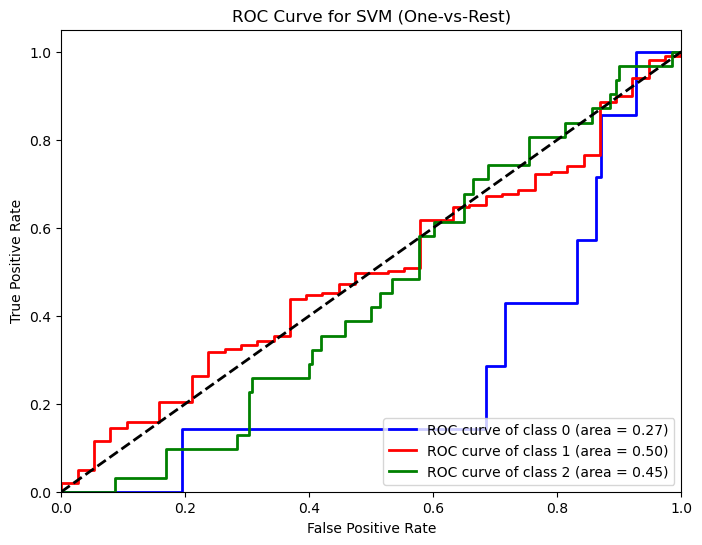

In [22]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classifier_ovr.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green'])  # Adjust colors as needed
for i, color in zip(range(len(classifier_ovr.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()

In [41]:


# Train a OneVsRestClassifier with SVM
classifier_ovr = OneVsRestClassifier(SVC(probability=True))
classifier_ovr.fit(x_train, y_train)

# Get predicted probabilities for each class
y_score = classifier_ovr.predict_proba(x_test)

# Binarize the labels for ROC curve calculation
y_test_bin = label_binarize(y_test, classes=classifier_ovr.classes_)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classifier_ovr.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green'])  # Adjust colors as needed
for i, color in zip(range(len(classifier_ovr.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()


ValueError: Expected 'estimator' to be a binary classifier. Got 3 classes instead.

In [ ]:
import pickle 

pickle.dump(best_estimator, open('/home/jovyan/work/model.p', 'wb'))


### K-fold cross-validation

In [ ]:
n_splits_values = [3, 5, 10]

for n_splits in n_splits_values:
    cv = KFold(n_splits=n_splits, random_state=42, shuffle=True)
    scores = cross_val_score(best_estimator, features, labels, scoring='accuracy', cv=cv, n_jobs=-1)
    print(f"{n_splits}-Fold CV: {scores.mean():.2f} accuracy with a standard deviation of {scores.std():.2f}")